In [222]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import re
import string
import nltk
from collections import Counter
from tqdm.auto import tqdm
from datetime import datetime

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn
from torch.optim import Adam, lr_scheduler
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

nltk.download('punkt_tab')
nltk.download('stopwords')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\glebp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\glebp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'cuda'

## Data installing

In [2]:
df = pd.read_csv(r'market_comments.csv').dropna()
df['tonality'] = df['tonality'].apply(lambda x: 1 if x=='positive' else 0)

## Data preparation and making custom Dataset

In [3]:
def clean_text(text):
    text = text.lower()  
    text = re.sub(f"[{string.punctuation}]", " ", text)  
    text = re.sub(r"\d+", " ", text)  
    words = word_tokenize(text)  
    words = [word for word in words if word not in stopwords.words('russian')]  
    return " ".join(words)

In [4]:
clean_text("Привет, как твои дела?")

'привет твои дела'

In [5]:
words = Counter()

for example in tqdm(df.comment):
    example = example.lower()
    example = re.sub(f"[{string.punctuation}]", "", example)  
    example = re.sub(r"\d+", "", example)
    for word in word_tokenize(example):
        words[word] += 1

vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Vocab size: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

100%|██████████| 14281/14281 [00:02<00:00, 4865.29it/s]

Vocab size: 2653


In [6]:
class WordDataset:
    def __init__(self, data):
        self.data = data
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx):
        processed_text = clean_text(self.data.iloc[idx].comment)
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data.iloc[idx].tonality}

        return train_sample

    def __len__(self) -> int:
        return len(self.data)

In [7]:
def collate_fn_with_padding(
        input_batch, pad_id=word2ind['<pad>'], max_len=128):
   
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.FloatTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

## Create and Make Model

In [ ]:
from transformers import AutoModel

class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model: str):
        super().__init__()
        
        self.backbone = AutoModel.from_pretrained(base_transformer_model)
        hidden_size = self.backbone.config.hidden_size
        self.classifier = nn.Linear(hidden_size, 1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask=None):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        pooled_output = last_hidden_state[:, 0]
        preds = self.sigmoid(self.classifier(pooled_output))
        return preds

In [9]:
def freeze_backbone_function(model: TransformerClassificationModel, state):
    for param in model.backbone.parameters():
        param.requires_grad = state
    return model

In [231]:
def train_transformer(model, train_loader,val_loader, num_epoch, learning_rate=1e-5, freeze_backbone=True):
    if freeze_backbone:
        freeze_backbone_function(model, False)
    else:
        freeze_backbone_function(model, True)

    optimizer = Adam(model.parameters(), lr=learning_rate)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)
    criterion = nn.BCEWithLogitsLoss()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    train_losses = []
    val_losses = []

    for epoch in range(1, num_epoch+1):   
        epoch_train_loss = []
        for i, batch in enumerate(tqdm(train_loader)):

            model.train()
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
        
            loss = criterion(logits.view(-1), batch['label'])
            loss.backward()
            optimizer.step()

            epoch_train_loss.append(loss.item())

        epoch_val_loss = []
        for i, batch in enumerate(tqdm(val_loader)):

            model.eval()
            logits = model(batch['input_ids'])
            loss = criterion(logits.view(-1), batch['label'])
        
            epoch_val_loss.append(loss.item())

        scheduler.step()

        model_dir = 'model_epochs'
        torch.save(model.state_dict(), os.path.join(model_dir, 'epoch-{}.pth'.format(epoch)))
        
        print(F"epoch: {epoch}.\nTrain Loss:{(sum(epoch_train_loss)/len(epoch_train_loss))}.\nVal Loss:{sum(epoch_val_loss)/len(epoch_val_loss)}.")
        
        train_losses.append((sum(epoch_train_loss)/len(epoch_train_loss)))
        val_losses.append(sum(epoch_val_loss)/len(epoch_val_loss))
        

    return model, train_losses, val_losses

In [219]:
train_data, test_data = train_test_split(df[['comment', 'tonality']], test_size=0.2)

train_dataset = WordDataset(train_data)
val_dataset = WordDataset(test_data)

print(f"Train data shape: {len(train_data)}.\nTest data shape: {len(test_data)}")


Train data shape: 11424.
Test data shape: 2857


In [220]:
BATCH_SIZE = 128
train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, shuffle=True,  batch_size=BATCH_SIZE)

val_dataloader = DataLoader(
    val_dataset, collate_fn=collate_fn_with_padding,shuffle=False, batch_size=BATCH_SIZE)

Take Albert model from Hugging Face

In [ ]:
albert_base_v2_model = TransformerClassificationModel('albert-base-v2').to(device)
albert_base_v2__finetuned, train_loss, val_loss= train_transformer(albert_base_v2_model, train_dataloader,val_dataloader, num_epoch=10, learning_rate=2e-5, freeze_backbone=False)

100%|██████████| 23/23 [01:46<00:00,  4.65s/it]


epoch: 1.
Train Loss:0.5419730792442957.
Val Loss:0.4940165955087413.


100%|██████████| 23/23 [01:47<00:00,  4.67s/it]


epoch: 2.
Train Loss:0.4654789702759849.
Val Loss:0.4701699497907058.


100%|██████████| 23/23 [01:41<00:00,  4.43s/it]


epoch: 3.
Train Loss:0.4513701770040724.
Val Loss:0.4659784319608108.


100%|██████████| 23/23 [01:42<00:00,  4.46s/it]


epoch: 4.
Train Loss:0.44939701855182645.
Val Loss:0.46407685202101.


100%|██████████| 23/23 [01:37<00:00,  4.23s/it]


epoch: 5.
Train Loss:0.4464848829640283.
Val Loss:0.4627599236757859.


100%|██████████| 23/23 [01:47<00:00,  4.67s/it]


epoch: 6.
Train Loss:0.4478457699219386.
Val Loss:0.46177948816962866.


100%|██████████| 23/23 [01:44<00:00,  4.54s/it]


epoch: 7.
Train Loss:0.44576095839341484.
Val Loss:0.4608000478018885.


100%|██████████| 23/23 [01:46<00:00,  4.63s/it]


epoch: 8.
Train Loss:0.4444672084516949.
Val Loss:0.4598218669062075.


100%|██████████| 23/23 [01:36<00:00,  4.20s/it]


epoch: 9.
Train Loss:0.44549571772416435.
Val Loss:0.45940035322438116.


100%|██████████| 23/23 [01:45<00:00,  4.58s/it]

epoch: 10.
Train Loss:0.44383358061313627.
Val Loss:0.45872502612031024.


In [234]:
res_training = pd.DataFrame({'Train': train_loss, 'Test': val_loss})


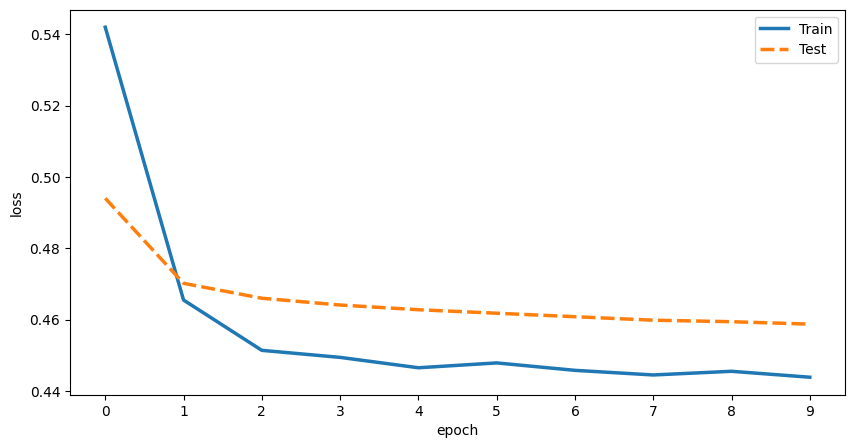

In [235]:
plt.figure(figsize=(10,5))
fig_acc = sns.lineplot(data=res_training, linewidth=2.5)
fig_acc.xaxis.set_major_locator(ticker.MultipleLocator(1)) 
fig_acc.set(xlabel='epoch', ylabel='loss')
plt.show()


In [240]:
model = albert_base_v2__finetuned_with_freezed_backbone

In [245]:
def get_preds(model, val_data):
    preds = []
    model.eval()

    for i in val_data:
        data = torch.tensor(i['text']).unsqueeze(0)
        preds.append(model(data).cpu().detach()[0][0])
    
    return preds

preds = get_preds(model.cpu(), val_dataset)
true = val_dataset.data.tonality

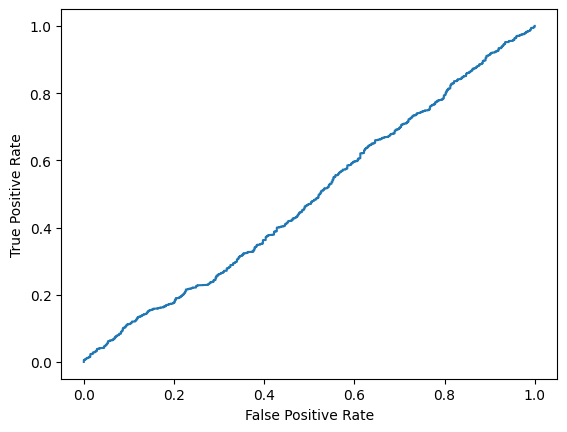

In [246]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(true,  preds)

# построение ROC кривой
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()